In [1]:
import argparse
from copy import deepcopy
import logging
import random
from collections import defaultdict
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
import joblib
import imodels
import inspect
import os.path
import imodelsx.cache_save_utils
import sys
import torch

#path_to_repo = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))

#os.chdir(path_to_repo)
#os.chdir('/home/mattyshen/interpretableDistillation')
sys.path.append('..')

import idistill.model
import idistill.data

def distill_model(student, X_train_teacher, y_train_teacher, r, feature_names = None):
    """Distill the teacher model using the student model"""
    
    fit_parameters = inspect.signature(student.fit).parameters.keys()
    if "feature_names" in fit_parameters and feature_names is not None:
        student.fit(X_train_teacher, y_train_teacher, feature_names=feature_names)
    else:
        student.fit(X_train_teacher, y_train_teacher)

    return r, student

def evaluate_student(student, X_train, X_test, y_train, y_test, metric, task, r):
    """Evaluate student performance on each split"""
    
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (X_, y_) in zip(
        ["train", "test"], [(X_train, y_train), (X_test, y_test)]
    ):
        y_pred_ = process_student_eval(student.predict(X_))
        r[f"student_{task}_{split_name}_{metric}"] = metric_fn(y_, y_pred_)

    return r

def evaluate_teacher(y_train_teacher, y_test_teacher, y_train, y_test, metric, task, r):
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    for split_name, (y_teacher_, y_) in zip(
        ["train", "test"], [(y_train_teacher, y_train), (y_test_teacher, y_test)]
    ):
        r[f"teacher_{task}_{split_name}_{metric}"] = metric_fn(y_teacher_, y_)
    
    return r

def predict_teacher(teacher, X, gpu=0):
    ### TODO: handle teacher prediction outputs (X is intended to be concept design matrix, output is intended to be logits)###

    y_pred_torch = teacher.sec_model(torch.tensor(X.values, dtype=torch.float32).to(f'cuda:{gpu}'))
    y_pred = pd.DataFrame(y_pred_torch.detach().cpu().numpy())
        
    return y_pred

def load_teacher_model(teacher_path, gpu=0):
    ### TODO: load in teacher model using teacher_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck')
    try:
        teacher = torch.load(teacher_path, weights_only=False)
    except:
        teacher = torch.load(join(join('home/mattyshen/DistillationEdit/', "models"), teacher_path), weights_only=False)
    teacher.to(f'cuda:{gpu}')
    teacher.eval()
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return teacher

def generate_tabular_distillation_data(teacher, train_path, test_path, gpu=0):
    ### TODO: generate teacher train and test data using model, train_path, and test_path ###
    
    sys.path.append('/home/mattyshen/ConceptBottleneck/CUB')
    from dataset import load_data
    from config import BASE_DIR
    
    def get_cub_data(teacher, path, data = 'train', override_train = True, batch_size = 32):
        with torch.no_grad():
            if data == 'test':
                test_dir = path
                #print(test_dir)
                # loader = load_data([test_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([test_dir], True, False, batch_size, image_dir='AdversarialData/CUB_fixed/test',
                                   n_class_attr=2)
            else:
                train_dir = path
                val_dir = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/val.pkl'
                #print(train_dir, val_dir)
                # loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='images',
                #                    n_class_attr=2, override_train=override_train)
                loader = load_data([train_dir, val_dir], True, False, batch_size, image_dir='AdversarialData/CUB_fixed/train',
                                    n_class_attr=2)
                
            torch.manual_seed(0)
            
            attrs_true = []
            attrs_hat = []
            labels_true = []
            labels_hat = []
            for data_idx, data in enumerate(loader):
                inputs, labels, attr_labels = data
                attr_labels = torch.stack(attr_labels).t()

                inputs_var = torch.autograd.Variable(inputs).to(f'cuda:{gpu}')
                labels_var = torch.autograd.Variable(labels).to(f'cuda:{gpu}')
                outputs = teacher(inputs_var)
                class_outputs = outputs[0]

                attr_outputs = outputs[1:]
                #attr_outputs_sigmoid = attr_outputs

                attrs_hat.append(torch.stack(attr_outputs).squeeze(2).detach().cpu().numpy())
                attrs_true.append(attr_labels.T)
                labels_hat.append(class_outputs.detach().cpu().numpy())
                labels_true.append(labels)

            X_hat = pd.DataFrame(np.concatenate(attrs_hat, axis=1).T, columns = [f'c{i}' for i in range(1, 113)])
            X = pd.DataFrame(np.concatenate(attrs_true, axis = 1).T, columns = [f'c{i}' for i in range(1, 113)])

            y = pd.Series(np.concatenate([l.numpy().reshape(-1, ) for l in labels_true]))
            y_hat = pd.DataFrame(np.concatenate(labels_hat, axis = 0))

            del attrs_hat
            del labels
            del labels_hat
            del loader
            del data
            del inputs
            del outputs
            del class_outputs
            del attr_outputs
            del inputs_var
            del labels_var
            torch.cuda.empty_cache()

            return X_hat, X, y_hat, y

    X_train_teacher, X_train, y_train_teacher, y_train = get_cub_data(teacher, train_path)
    X_test_teacher, X_test, y_test_teacher, y_test = get_cub_data(teacher, test_path, data = 'test')
    
    sys.path.append('/home/mattyshen/DistillationEdit')
    
    return X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher, y_train, y_test
    
def process_distillation_data(X_train_teacher, X_test_teacher, X_train, X_test, y_train_teacher, y_test_teacher):
    ### TODO: process (i.e. binarize, F1-max binarize) data for distillation ###
    
    thresh = 0
    
#     return (X_train_teacher > thresh).astype(int), (X_test_teacher > thresh).astype(int), y_train_teacher, y_test_teacher

    # best_t = np.argmax([np.mean((X_train_teacher.values > t).astype(int) == X_train.values) for t in np.arange(0, 1, 0.01)])
    # thresh = np.arange(0, 1, 0.01)[best_t]
    
    return (X_train_teacher > thresh).astype(int), (X_test_teacher > thresh).astype(int), y_train_teacher, y_test_teacher

def process_student_eval(y_student):
    ### TODO: handle student prediction outputs to match metrics ###
    
    y_pred = np.argmax(y_student, axis = 1)

    return y_pred

def process_teacher_eval(y_teacher):
    ### TODO: process teacher model predictions for evaluations (sometimes we distill a teacher model using a regressor, but want to evaluate class prediction accuracy) ###
    
    y_teacher_eval = y_teacher.idxmax(axis = 1).astype(int).values
    
    return y_teacher_eval

def extract_interactions(student):

    interactions = []

    def traverse_tree(node, current_features, current_depth):

        if node.left is None and node.right is None:
            tree_interactions.append((current_features, np.var(np.abs(node.value))))
            return
        if node.left is not None:
            current_features_l = current_features.copy()
            current_features_l.append('c' + str(node.feature+1))
            traverse_tree(node.left, current_features_l.copy(), current_depth=current_depth+1)
        if node.right is not None:
            current_features_r = current_features.copy()
            current_features_r.append('!c' + str(node.feature+1))
            traverse_tree(node.right, current_features_r.copy(), current_depth=current_depth+1)
            
    try:
        trees = student.trees_
    except:
        trees = student.figs.trees_

    for tree in trees:
        tree_interactions = []
        traverse_tree(tree, [], current_depth=0)
        interactions.append(tree_interactions)
        
    return interactions

def get_argmax_max(vals, index):
    
    maxes = np.sort(vals, axis=1)[:, -index]
    argmaxes = np.argsort(vals, axis=1)[:, -index]
    return maxes, argmaxes

def extract_adaptive_intervention(student, X, interactions, number_of_top_paths, tol = 0.0001):
    
    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    for idx in range(number_of_top_paths):
        maxes, argmaxes = get_argmax_max(variances, idx+1)
        for i, (tree_idx, var) in enumerate(zip(argmaxes, maxes)):
            for paths in interactions[tree_idx]:
                if abs(paths[1] - var) < tol:
                    concept_indexes = [int(p[1:])-1 if p[0] != '!' else int(p[2:])-1 for p in paths[0]]
                    concepts_to_edit[i].append(concept_indexes)
                    
    concepts_to_edit = [sum(element, []) for element in concepts_to_edit]
    concepts_to_edit = [list(set(c)) for c in concepts_to_edit]
    
    return concepts_to_edit

/home/mattyshen/anaconda3/lib/python3.9/site-packages/aiohttp/helpers.py:107: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def noop(*args, **kwargs):  # type: ignore
2025-02-07 14:57:41.973153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-07 14:57:43.106633: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:34: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as

In [2]:
class ARGS:
    def __init__(self, a_dict):
        for k in a_dict.keys():
            exec(f'self.{k} = a_dict["{k}"]')
        

In [7]:
args = {}
#args['save_dir'] = join(path_to_repo, "results")  # The default value
args['teacher_path'] = '/home/mattyshen/DistillationEdit/models/travelingbirds/outputs/best_Joint0.01_Linear_model_1.pth'  # The default value
args['train_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/train.pkl'  # The default value
args['test_path'] = '/home/mattyshen/ConceptBottleneck/CUB_processed/class_attr_data_10/test.pkl'  # The default value
args['task_type'] = "regression"  # The default value
args['student_name'] = "FIGSRegressor"  # The default value
args['max_rules'] = 200  # The default value
args['max_trees'] = 30  # The default value
args['max_depth'] = 4  # The default value
args['min_impurity_decrease'] = 0  # The default value
args['metric'] = "accuracy"  # The default value
args['num_interactions_intervention'] = 3  # The default value
args['n_trees_list'] = [30,40]
args['n_rules_list'] = [125, 150, 200]
args['n_depth_list'] = [4]
args['min_impurity_decrease_list'] = [0]
args['gpu'] = 0

args = ARGS(args)

In [8]:
r = defaultdict(list)

In [9]:
teacher = load_teacher_model(args.teacher_path, args.gpu)
    
X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t, y_train, y_test = generate_tabular_distillation_data(teacher, args.train_path, args.test_path, args.gpu)

X_train_d, X_test_d, y_train_d, y_test_d = process_distillation_data(X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t)

y_train_t_eval = process_teacher_eval(y_train_t)
y_test_t_eval = process_teacher_eval(y_test_t)

In [10]:
X_train_d, X_test_d, y_train_d, y_test_d = process_distillation_data(X_train_t, X_test_t, X_train, X_test, y_train_t, y_test_t)

y_train_t_eval = process_teacher_eval(y_train_t)
y_test_t_eval = process_teacher_eval(y_test_t)

In [11]:
np.mean(X_train_d.values)

0.20221931101986249

In [12]:
figs_student = idistill.model.get_model(args.task_type, args.student_name, args)

In [13]:
figs_student

FIGSRegressor(max_depth=4, max_rules=200, max_trees=30)

In [14]:
r, figs_student = distill_model(figs_student, X_train_d, y_train_d, r)

In [15]:
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train_t_eval, y_test_t_eval, args.metric, "distillation", r)
r = evaluate_student(figs_student, X_train_d, X_test_d, y_train, y_test, args.metric, "prediction", r)

r = evaluate_teacher(y_train_t_eval, y_test_t_eval, y_train, y_test, args.metric, "prediction", r)

In [16]:
r

defaultdict(list,
            {'student_distillation_train_accuracy': 0.9495320855614974,
             'student_distillation_test_accuracy': 0.6929582326544701,
             'student_prediction_train_accuracy': 0.9428475935828877,
             'student_prediction_test_accuracy': 0.48015188125647223,
             'teacher_prediction_train_accuracy': 0.97576871657754,
             'teacher_prediction_test_accuracy': 0.5177770107007249})

In [17]:
figs_interactions = extract_interactions(figs_student)

In [18]:
figs_dict = {}
for i, tree in enumerate(figs_interactions):
    tree_dict = {}
    for path, var in tree:
        tree_dict[var] = path
    figs_dict[i] = tree_dict

In [140]:
figs_dict

{0: {1.0012138758859954: ['c5', 'c103', 'c112'],
  1.9102023650478281: ['c5', 'c103', '!c112'],
  5.19747671374064: ['c5', '!c103', 'c112'],
  5.352298446420224: ['c5', '!c103', '!c112'],
  2.7819014311876127: ['!c5', 'c85', 'c104'],
  6.530196952878374: ['!c5', 'c85', '!c104'],
  6.4646118369995635: ['!c5', '!c85', 'c104'],
  9.643062505000852: ['!c5', '!c85', '!c104']},
 1: {0.22466101116584244: ['c73', 'c95', 'c96'],
  3.411789524782311: ['c73', 'c95', '!c96'],
  1.7480126719060078: ['c73', '!c95', 'c30'],
  6.446726802358334: ['c73', '!c95', '!c30'],
  4.494267445722651: ['!c73', 'c13', 'c52'],
  5.215697571983405: ['!c73', 'c13', '!c52'],
  6.0125948646311675: ['!c73', '!c13', 'c47'],
  8.293991402590708: ['!c73', '!c13', '!c47']},
 2: {0.42270395002616845: ['c29', 'c17', 'c8'],
  0.21469749654858808: ['c29', 'c17', '!c8'],
  3.7002923926587505: ['c29', '!c17', 'c22'],
  4.294512514548336: ['c29', '!c17', '!c22'],
  1.3891875224235997: ['!c29', 'c74', 'c45'],
  1.8262056671560458:

In [19]:
def find_closest_keys_vectorized(dictionary, targets):
    keys = np.array(list(dictionary.keys()))
    targets = np.array(targets)
    diffs = np.abs(keys[:, None] - targets) 
    closest_key_indices = np.argmin(diffs, axis=0)
    closest_keys = keys[closest_key_indices]

    return closest_keys

In [20]:
def extract_adap_interv_plot(student, X, interactions, number_of_top_paths=0):

    
    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)

    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                new_list.append(int(c[1:])-1 if c[0] != '!' else int(c[2:])-1)
            concepts_to_edit[i].append(new_list)
    return concepts_to_edit

In [21]:
figs_interactions = extract_interactions(figs_student)

train_q5 = np.quantile(X_train_t, 0.05, axis = 0)
train_q95 = np.quantile(X_train_t, 0.95, axis = 0)

In [22]:
def split_list_by_sizes(list1, list2):
    result = []
    for row1, row2 in zip(list1, list2):
        sizes = [len(sublist) for sublist in row1]  # Get the sizes from the first list row
        row_result = []
        start = 0
        for size in sizes:
            end = start + size
            row_result.append(list(row2[start:end]))  # Slice the second row by size
            start = end
        result.append(row_result)
    return result

In [23]:
cti_adap_test = extract_adap_interv_plot(figs_student, X_test_d, figs_interactions)

cti_rand_test = [np.random.choice(np.arange(112), 112, replace=False) for i in range(X_test_d.shape[0])]
cti_rand_test = split_list_by_sizes(cti_adap_test, cti_rand_test)

test_l_edit = np.einsum('nc, yc -> nyc', X_test_t.values, teacher.sec_model.linear.weight.cpu().detach().numpy())

cti_l_test_arr = np.argsort(np.var(np.abs(test_l_edit), axis = 1), axis = 1)[:, ::-1]
cti_l_test = [row for row in cti_l_test_arr]
cti_l_test = split_list_by_sizes(cti_adap_test, cti_l_test)

In [24]:
X_test_d_a_edit = X_test_d.copy()
X_test_d_r_edit = X_test_d.copy()
X_test_d_l_edit = X_test_d.copy()
X_test_t_a_edit = X_test_t.copy()
X_test_t_r_edit = X_test_t.copy()
X_test_t_l_edit = X_test_t.copy()

In [25]:
def evaluate_test_student(student, X_test, y_test, metric, task, r):
    """Evaluate student performance on each split"""
    
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    y_pred_ = process_student_eval(student.predict(X_test))
    r[f"student_{task}_test_{metric}"] = metric_fn(y_test, y_pred_)

    return r

def evaluate_test_teacher(y_test_teacher, y_test, metric, task, r):
    metrics = {
            "accuracy": accuracy_score,
            "mse": mean_squared_error,
            "r2": r2_score,
            "f1": f1_score,
        
        }
    
    metric_fn = metrics[metric]
    
    r[f"teacher_{task}_test_{metric}"] = metric_fn(y_test_teacher, y_test)
    
    return r

In [26]:
for i in range(len(figs_student.trees_)):
    print(f'iter {i}')
    for n in range(X_test_d.shape[0]):

        X_test_d_a_edit.iloc[n, cti_adap_test[n][i]] = X_test.iloc[n, cti_adap_test[n][i]]
        X_test_d_r_edit.iloc[n, cti_rand_test[n][i]] = X_test.iloc[n, cti_rand_test[n][i]]
        X_test_d_l_edit.iloc[n, cti_l_test[n][i]] = X_test.iloc[n, cti_l_test[n][i]]

        X_test_t_a_edit.iloc[n, cti_adap_test[n][i]] = train_q5[cti_adap_test[n][i]]*(X_test.iloc[n, cti_adap_test[n][i]] == 0) + train_q95[cti_adap_test[n][i]]*(X_test.iloc[n, cti_adap_test[n][i]])
        X_test_t_r_edit.iloc[n, cti_rand_test[n][i]] = train_q5[cti_rand_test[n][i]]*(X_test.iloc[n, cti_rand_test[n][i]] == 0) + train_q95[cti_rand_test[n][i]]*(X_test.iloc[n, cti_rand_test[n][i]])
        X_test_t_l_edit.iloc[n, cti_l_test[n][i]] = train_q5[cti_l_test[n][i]]*(X_test.iloc[n, cti_l_test[n][i]] == 0) + train_q95[cti_l_test[n][i]]*(X_test.iloc[n, cti_l_test[n][i]])

    y_test_t_eval_a_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_a_edit))
    y_test_t_eval_r_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_r_edit))
    y_test_t_eval_l_interv = process_teacher_eval(predict_teacher(teacher, X_test_t_l_edit))

    r = evaluate_test_student(figs_student, X_test_d_a_edit, y_test_t_eval_a_interv, args.metric, f"distill_adap_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_r_edit, y_test_t_eval_r_interv, args.metric, f"distill_rand_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_l_edit, y_test_t_eval_l_interv, args.metric, f"distill_lin_interv_iter{i}", r)

    r = evaluate_test_student(figs_student, X_test_d_a_edit, y_test, args.metric, f"pred_adap_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_r_edit, y_test, args.metric, f"pred_rand_interv_iter{i}", r)
    r = evaluate_test_student(figs_student, X_test_d_l_edit, y_test, args.metric, f"pred_lin_interv_iter{i}", r)

    r = evaluate_test_teacher(y_test_t_eval_a_interv, y_test, args.metric, f"pred_adap_interv_iter{i}", r)
    r = evaluate_test_teacher(y_test_t_eval_r_interv, y_test, args.metric, f"pred_rand_interv_iter{i}", r)
    r = evaluate_test_teacher(y_test_t_eval_l_interv, y_test, args.metric, f"pred_lin_interv_iter{i}", r)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24
iter 25
iter 26
iter 27
iter 28
iter 29


In [44]:
cti_l_test[0]

[[6, 23, 109],
 [53, 39, 37],
 [12, 87, 80],
 [46, 27, 56],
 [24, 85, 69],
 [45, 102, 105],
 [55, 44, 36],
 [15, 75, 59],
 [95, 103, 104],
 [71, 4, 70],
 [66, 98, 81],
 [49, 9, 63],
 [16, 30, 72],
 [99, 54, 21],
 [65, 41, 77],
 [0, 3, 64],
 [40, 90, 2],
 [17, 18, 10],
 [84, 88, 93],
 [32, 96, 35],
 [92, 110, 111],
 [5, 33, 101],
 [60, 31, 25],
 [91, 51, 79],
 [82, 61, 52],
 [29, 78, 13],
 [76, 108, 26],
 [14, 89, 62],
 [107, 106, 83],
 [86]]

In [42]:
cti_adap_test[0]

[[28, 73, 44],
 [79, 81, 1],
 [4, 102, 111],
 [47, 18, 68],
 [28, 67, 31],
 [91, 20, 94],
 [99, 35, 68],
 [72, 94, 95],
 [38, 82, 86],
 [97, 46, 57],
 [83, 0, 108],
 [2, 4, 63],
 [40, 109, 31],
 [77, 85, 43],
 [76, 6, 110],
 [60, 23, 89],
 [87, 96, 45],
 [105, 24, 107],
 [75, 80, 22],
 [94, 74, 49],
 [0, 51, 33],
 [42, 61, 35],
 [101, 88, 65],
 [7, 1, 13],
 [106, 49, 55],
 [86, 69, 110],
 [29, 58, 55],
 [50, 104, 8],
 [4, 103, 32],
 [111]]

In [27]:
t_a_pred = [r['teacher_prediction_test_accuracy']]
t_r_pred = [r['teacher_prediction_test_accuracy']]
t_l_pred = [r['teacher_prediction_test_accuracy']]

s_a_pred = [r['student_prediction_test_accuracy']]
s_r_pred = [r['student_prediction_test_accuracy']]
s_l_pred = [r['student_prediction_test_accuracy']]

s_a_distill = [r['student_distillation_test_accuracy']]
s_r_distill = [r['student_distillation_test_accuracy']]
s_l_distill = [r['student_distillation_test_accuracy']]

In [28]:
for i in range(30):
    t_a_pred.append(r[f'teacher_pred_adap_interv_iter{i}_test_accuracy'])
    t_r_pred.append(r[f'teacher_pred_rand_interv_iter{i}_test_accuracy'])
    t_l_pred.append(r[f'teacher_pred_lin_interv_iter{i}_test_accuracy'])
    
    s_a_pred.append(r[f'student_pred_adap_interv_iter{i}_test_accuracy'])
    s_r_pred.append(r[f'student_pred_rand_interv_iter{i}_test_accuracy'])
    s_l_pred.append(r[f'student_pred_lin_interv_iter{i}_test_accuracy'])
    
    s_a_distill.append(r[f'student_distill_adap_interv_iter{i}_test_accuracy'])
    s_r_distill.append(r[f'student_distill_rand_interv_iter{i}_test_accuracy'])
    s_l_distill.append(r[f'student_distill_lin_interv_iter{i}_test_accuracy'])

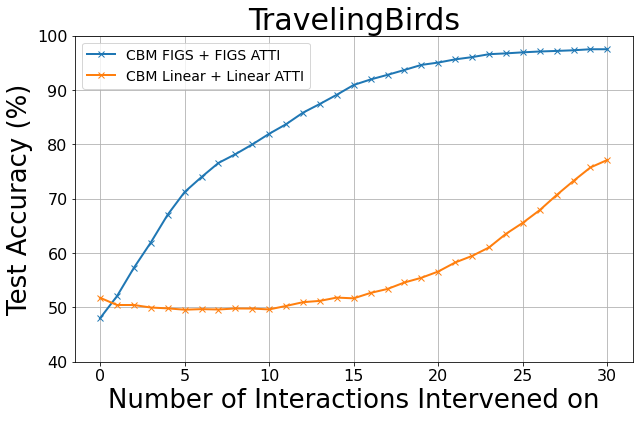

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['legend.title_fontsize'] = 14
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_pred)*100, label='CBM FIGS + FIGS ATTI', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='CBM Linear + Linear ATTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on", fontsize = 26)
plt.ylim(40, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 26)
plt.title("TravelingBirds")
plt.legend(fontsize = 14)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_aTTI_Effect.png', bbox_inches='tight')

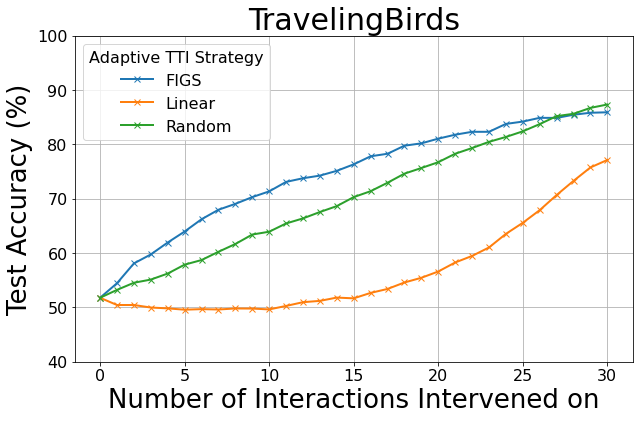

In [126]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(t_a_pred)*100, label='FIGS', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='Linear', linewidth=2, marker='x')
plt.plot(x, np.array(t_r_pred)*100, label='Random', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on", fontsize = 26)
plt.ylim(40, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 26)
plt.title("TravelingBirds")
plt.legend(title='Adaptive TTI Strategy', fontsize = 16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_aTTI_Effect_Diff.png', bbox_inches='tight')

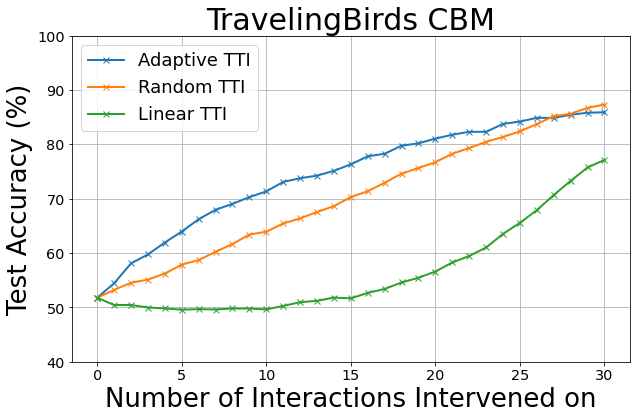

In [116]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.titlesize'] = 30
# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(t_a_pred)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(t_r_pred)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(t_l_pred)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervened on", fontsize = 26)
plt.ylabel("Test Accuracy (%)", fontsize = 26)
plt.ylim(40, 100)
plt.title("TravelingBirds CBM")
plt.legend(fontsize = 18)
plt.grid(True)
# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_teacher.png', bbox_inches='tight')

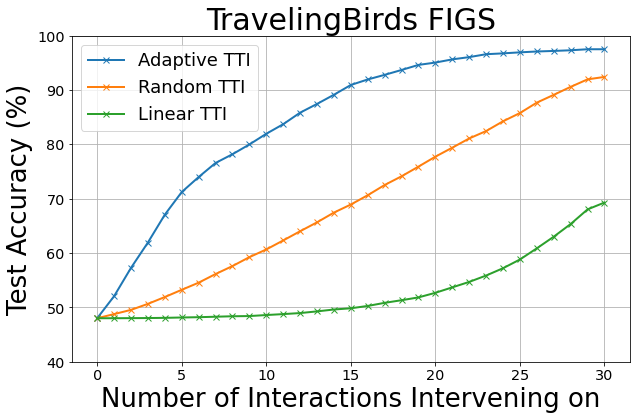

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_pred)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_r_pred)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_l_pred)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervening on", fontsize = 26)
plt.ylim(40, 100)
plt.ylabel("Test Accuracy (%)", fontsize = 26)
plt.title("TravelingBirds FIGS")
plt.legend(fontsize=18)
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_student.png', bbox_inches='tight')

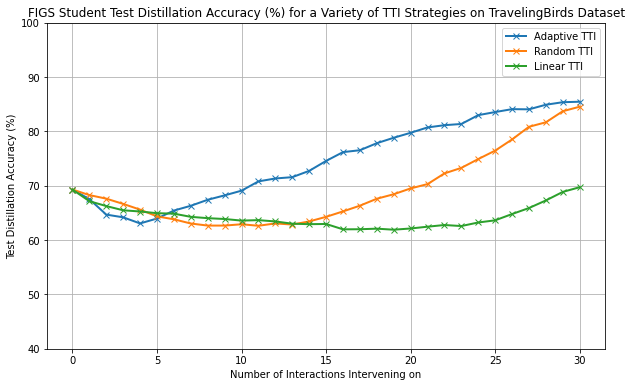

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define x-axis range
x = np.arange(0, 31)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, np.array(s_a_distill)*100, label='Adaptive TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_r_distill)*100, label='Random TTI', linewidth=2, marker='x')
plt.plot(x, np.array(s_l_distill)*100, label='Linear TTI', linewidth=2, marker='x')

# Labels and legend
plt.xlabel("Number of Interactions Intervening on")
plt.ylim(40, 100)
plt.ylabel("Test Distillation Accuracy (%)")
plt.title("FIGS Student Test Distillation Accuracy (%) for a Variety of TTI Strategies on TravelingBirds Dataset")
plt.legend()
plt.grid(True)

# Show the plot
plt.savefig('/home/mattyshen/DistillationEdit/figures/tti/TravelingBirds_TTI_student_distillation.png', bbox_inches='tight')

In [173]:
def rank_concepts(student, X, interactions, number_of_top_paths=0):
    
    figs_dict = {}
    for i, tree in enumerate(interactions):
        tree_dict = {}
        for path, var in tree:
            tree_dict[var] = path
        figs_dict[i] = tree_dict

    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)
    print(variances.shape)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)
    concept_scores = {}
    concept_counts = {}
    for i in range(0, 112):
        concept_scores[i] = 0
        concept_counts[i] = 0
    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                
                concept = int(c[1:])-1 if c[0] != '!' else int(c[2:])-1
                assert variances_of_orderings_of_interventions[i, t] > 0, "negative variance?"
                concept_scores[concept] += variances_of_orderings_of_interventions[i, t]
                concept_counts[concept] += 1

    return concept_scores, concept_counts

In [174]:
def rank_interactions(student, X, interactions, number_of_top_paths=0):
    
    figs_dict = {}
    for i, tree in enumerate(interactions):
        tree_dict = {}
        for path, var in tree:
            tree_dict[var] = path
        figs_dict[i] = tree_dict

    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)
    interaction_scores = {}
    interaction_counts = {}
    for i in range(0, 112):
        concept_scores[i] = 0
        concept_counts[i] = 0
    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                
                concept = int(c[1:])-1 if c[0] != '!' else int(c[2:])-1
                assert variances_of_orderings_of_interventions[i, t] > 0, "negative variance?"
                concept_scores[concept] += variances_of_orderings_of_interventions[i, t]
                concept_counts[concept] += 1

    return concept_scores, concept_counts

In [179]:
len(list(c_counts.keys()))

112

In [175]:
c_scores, c_counts = rank_concepts(figs_student, X_train_d, figs_interactions)

(5984, 30)


In [148]:
np.array([c_scores[c] / c_counts[c] if c_counts[c] != 0 else 0 for c in range(0, 112)])

array([0.08839095, 0.41505429, 0.21388324, 1.28947109, 1.05176837,
       0.05979865, 0.07591372, 0.25975633, 0.20866436, 0.80004146,
       0.91890258, 0.        , 5.82754645, 0.01810811, 0.06233718,
       0.09960716, 0.46759955, 0.16081072, 0.31018842, 0.02559458,
       0.29444148, 3.67808225, 0.05600386, 0.27701866, 0.15947204,
       0.        , 0.25225394, 0.        , 0.72711342, 0.77323655,
       0.22119349, 0.08455332, 0.01222593, 0.65335375, 0.15273556,
       0.04772996, 0.39719841, 0.07884077, 0.11733309, 0.70038614,
       0.28399161, 0.        , 0.01940765, 0.03070267, 1.4590914 ,
       0.05213891, 0.65407198, 0.21648212, 0.        , 0.02922067,
       0.02747254, 0.4170051 , 0.1144363 , 0.        , 0.        ,
       0.00923588, 0.        , 0.22325684, 0.02499642, 0.12631669,
       0.23264936, 0.0238911 , 0.1861808 , 0.09926424, 0.        ,
       0.02183747, 0.        , 0.07999443, 0.07890584, 0.10372693,
       0.        , 0.        , 1.99003531, 1.60840003, 0.01499

In [ ]:
ranking_concepts(figs_student, X_train_d, interactions, number_of_top_paths=0)

In [128]:
np.argsort(figs_student.feature_importances_)

array([ 11,  71,  70,  66,  41,  27,  64,  48,  25,  53,  54,  56,  74,
       106,  13,  61,  90,  42,  19,   5,  39,  59,  49,  32,  55,  86,
        92,  18, 110,  10,  78,  58,  57,  35,  82,  98,  17,  44,  63,
         3,  68,   1,  62,  65,  33,  22,  93,  21,  51,  36,  43,  14,
        50,   9,  89, 100,   8,  46,  30, 107,  12,  34,   0,  81,  87,
        15, 101, 108,  38, 105,  75,   6,  76,  47,  24,   2,  88, 109,
        45,  52,  67,  85,  84,  26,  29, 102,  20,   7,  31, 104,  69,
       103,  99,  37,  23,  77,  95,  73,  97,  60,  96,  16, 111,  80,
        40,  79,  94,  83,  72,  28,  91,   4])

In [129]:
figs_student.feature_importances_[4]

0.12300349784959154

In [131]:
figs_student.feature_importances_[74]

6.676444453625507e-05

In [137]:
np.argsort(np.mean(np.abs(teacher.sec_model.linear.weight.cpu().detach().numpy()), axis = 0))

array([ 57,  48, 110,  78, 111,  32,  91,  11,  51,  63,  76,  90, 108,
        43,  16,  21,  40,  25,  68,   3,  26, 106,  84,   7,  86,  38,
        36,  59,  13,  28,  70,  49,  54, 105,  98,   9, 100,   8, 101,
        99,  60,  85,  34,  75,  65,  67,  17,  30,  44,  58,  20,  64,
        88,  50,  56,  29,  55,  96,  73,  94,  42, 103,  71,  74,  14,
        77,  79,  18,   6,  35,  95,  87,  92,  80,  19,  27,  66,  62,
       102,  10,  24,  15,  97, 107,   2,  69, 104,   5,  33,  31,   1,
        83,   0,  23,  81,  72,  37,  39,  61,  12,  45,  41,  82,  47,
         4,  46,  93,  89, 109,  22,  53,  52])

In [156]:
#linear
np.argsort(np.mean(np.var(np.abs(np.einsum('nc, yc -> nyc', X_train_t.values, teacher.sec_model.linear.weight.cpu().detach().numpy())), axis = 1), axis = 0))

array([ 78,  76, 100,  86,  48,  50,  57,   7,  13,  83,  89,  51,  74,
        82,  22,  20,  43,  34,  11, 108, 106,   2, 111,  61,  91,  31,
        97,   3, 110,  26,  38,  32,  52,  96,  28,  67,  25,  90,   8,
        77,  65,  10,  68,  14,  47,  21,  62,  98,  99,  54,   5,  60,
        84,  59,   9,  93,  19,  33,  63,  64,  40,  49,   4,  88,  94,
        79,  16,  29, 103,  30,  55,  42,  44,  75,  36,  92,  18,  15,
        35,  17,  71,  69,  80,  73,  41,  72, 104,  58, 105,  56,  87,
        85,  70,  12,  46,  95,   6, 101, 107,  24,  66,   0,  39, 102,
        27,  23,  37,   1,  45,  81, 109,  53])

In [160]:
#linear feature importance
np.argsort(np.mean(np.abs(teacher.sec_model.linear.weight.cpu().detach().numpy()), axis = 0))

array([ 57,  48, 110,  78, 111,  32,  91,  11,  51,  63,  76,  90, 108,
        43,  16,  21,  40,  25,  68,   3,  26, 106,  84,   7,  86,  38,
        36,  59,  13,  28,  70,  49,  54, 105,  98,   9, 100,   8, 101,
        99,  60,  85,  34,  75,  65,  67,  17,  30,  44,  58,  20,  64,
        88,  50,  56,  29,  55,  96,  73,  94,  42, 103,  71,  74,  14,
        77,  79,  18,   6,  35,  95,  87,  92,  80,  19,  27,  66,  62,
       102,  10,  24,  15,  97, 107,   2,  69, 104,   5,  33,  31,   1,
        83,   0,  23,  81,  72,  37,  39,  61,  12,  45,  41,  82,  47,
         4,  46,  93,  89, 109,  22,  53,  52])

In [157]:
#figs
np.argsort(np.array([c_scores[c] / c_counts[c] if c_counts[c] != 0 else 0 for c in range(0, 112)]))

array([ 66,  41,  48,  53,  54,  56,  27,  25,  64,  70,  71,  11,  55,
        32,  74, 106,  13,  42,  65,  61,  58,  19,  92,  50, 110,  49,
        90,  43,  93,  89,  86,  35,  45,  88,  98,  22,   5,  14,   6,
        37,  68,  67,  31, 107,   0,  97,  63,  15,  69,  96,  99, 101,
        76,  52,  38,  77,  59, 108, 109,  34,  24,  17,  83,  75,  62,
       104,  85,  80,   8,   2,  47,  30,  57,  60,  87,  26,   7, 105,
        23,  40,  20,  82,  18,  36,   1,  51,  16,  95,  94,  91,  33,
        46,  79, 111,  39,  28,  29, 100,   9,  10,   4,  78, 103,   3,
        44, 102,  73,  81,  72,  84,  21,  12])

In [159]:
#figs feature importance
np.argsort(figs_student.feature_importances_)

array([ 11,  71,  70,  66,  41,  27,  64,  48,  25,  53,  54,  56,  74,
       106,  13,  61,  90,  42,  19,   5,  39,  59,  49,  32,  55,  86,
        92,  18, 110,  10,  78,  58,  57,  35,  82,  98,  17,  44,  63,
         3,  68,   1,  62,  65,  33,  22,  93,  21,  51,  36,  43,  14,
        50,   9,  89, 100,   8,  46,  30, 107,  12,  34,   0,  81,  87,
        15, 101, 108,  38, 105,  75,   6,  76,  47,  24,   2,  88, 109,
        45,  52,  67,  85,  84,  26,  29, 102,  20,   7,  31, 104,  69,
       103,  99,  37,  23,  77,  95,  73,  97,  60,  96,  16, 111,  80,
        40,  79,  94,  83,  72,  28,  91,   4])

In [184]:
figs_student.feature_importances_[28]

0.05682562481857771

In [185]:
plt.bar(figs_student.feature_importances_)

TypeError: bar() missing 1 required positional argument: 'height'

In [ ]:
def find_paths(student, X, interactions, number_of_top_paths=0):
    
    figs_dict = {}
    for i, tree in enumerate(interactions):
        tree_dict = {}
        for path, var in tree:
            tree_dict[var] = path
        figs_dict[i] = tree_dict

    test_pred_intervention = student.predict(X, by_tree = True)

    concepts_to_edit = [[] for _ in range(X.shape[0])]
    variances = np.var(np.abs(test_pred_intervention), axis = 1)
    print(variances.shape)

    concepts = np.array([find_closest_keys_vectorized(figs_dict[i], variances[:, i]) for i in range(variances.shape[1])])
    orderings_of_interventions = np.argsort(concepts.T, axis = 1)[:, ::-1]
    variances_of_orderings_of_interventions = np.sort(concepts.T, axis = 1)[:, ::-1]
    
    if number_of_top_paths == 0:
        r = range(orderings_of_interventions.shape[1])
    else:
        r = range(number_of_top_paths)
    concept_scores = {}
    concept_counts = {}
    for i in range(0, 112):
        concept_scores[i] = 0
        concept_counts[i] = 0
    for t in r:
        for i, l in enumerate(orderings_of_interventions[:, t]):
            new_list = []
            for c in figs_dict[l][variances_of_orderings_of_interventions[i, t]]:
                
                concept = int(c[1:])-1 if c[0] != '!' else int(c[2:])-1
                assert variances_of_orderings_of_interventions[i, t] > 0, "negative variance?"
                concept_scores[concept] += variances_of_orderings_of_interventions[i, t]
                concept_counts[concept] += 1

    return concept_scores, concept_counts